In [1]:
!pip install seaborn

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installedpython
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import precision_recall_curve,average_precision_score,roc_auc_score,classification_report,confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-fraud-detection-dataset-2023/creditcard_2023.csv


In [3]:
# read data
df=pd.read_csv(files[0])
df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,5.686300e+05,5.686300e+05,568630.000000,568630.000000,568630.000000,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.118237e-17,-1.023647e-16,1.023647e-16,0.000000,2.559118e-17,2.559118e-17,0.000000,0.000000,0.000000,...,1.279559e-17,1.599449e-18,6.397796e-18,-2.559118e-17,-3.838678e-17,0.000000,-2.559118e-17,3.838678e-17,12041.957635,0.5
std,164149.486121,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,1.000001,1.000001,1.000001,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222,-9.952786e+00,-2.111111e+01,-4.351839,-10.756342,-3.751919,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-0.656020,-2.934955e-01,-4.458712e-01,-0.283533,-0.192257,-0.568745,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-0.631895,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-0.073762,8.108788e-02,7.871758e-02,0.233366,-0.114524,0.092526,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-0.011892,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,0.707005,4.397368e-01,4.977881e-01,0.525955,0.047299,0.559262,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,0.672888,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536,4.271689e+01,2.616840e+01,217.873038,5.958040,20.270062,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285,1.132311e+02,7.725594e+01,24039.930000,1.0


In [4]:
# select input, x and true value, y
features=[col for col in df.columns if col not in ('id','Class')]
x=df[features].copy()
y=df['Class'] # 0: normal , 1: fraud

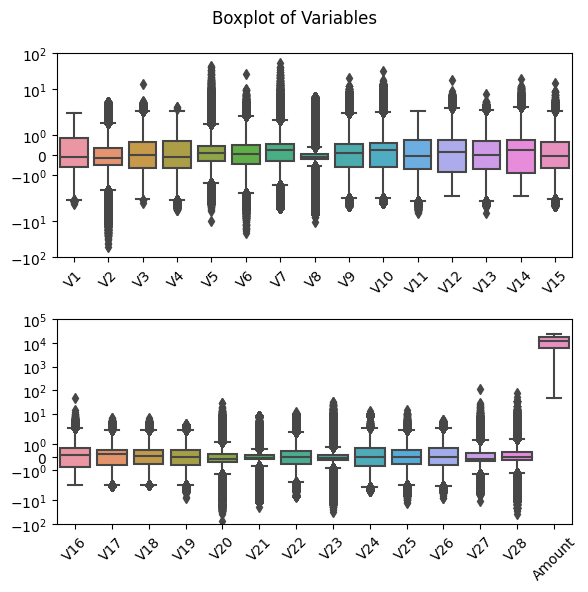

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(6,6))
plt.suptitle('Boxplot of Variables')
sns.boxplot(data=df[features[:15]],ax=ax[0])
sns.boxplot(data=df[features[15:]],ax=ax[1])
ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')
ax[0].set_ylim(-100,100)
ax[1].set_ylim(-100,1e5)
ax[0].tick_params('x',labelrotation=45)
ax[1].tick_params('x',labelrotation=45)
plt.tight_layout()
plt.savefig('variables_boxplot.jpg',dpi=150)


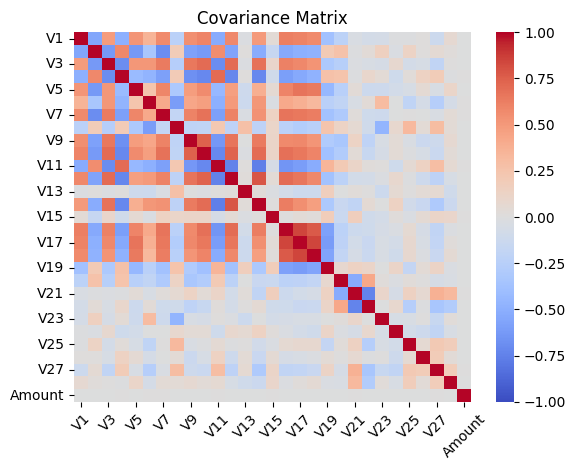

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

x_mean=x.mean()
x_std=x.std()
z=(x-x_mean)/x_std
c=z.cov()
sns.heatmap(c,cmap='coolwarm',vmax=1,vmin=-1)
plt.title('Covariance Matrix')
plt.xticks(rotation=45)
plt.savefig('covariance_matrix.jpg',dpi=150)

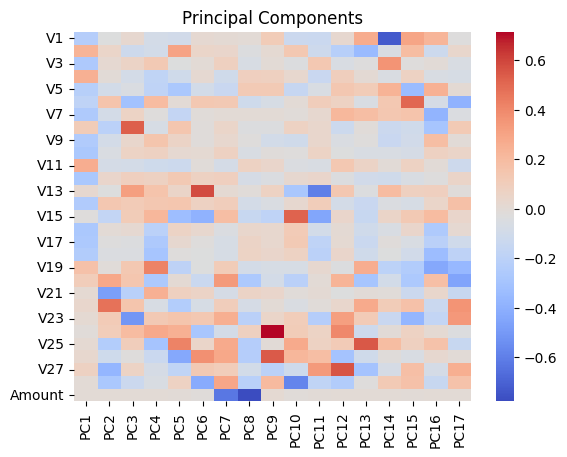

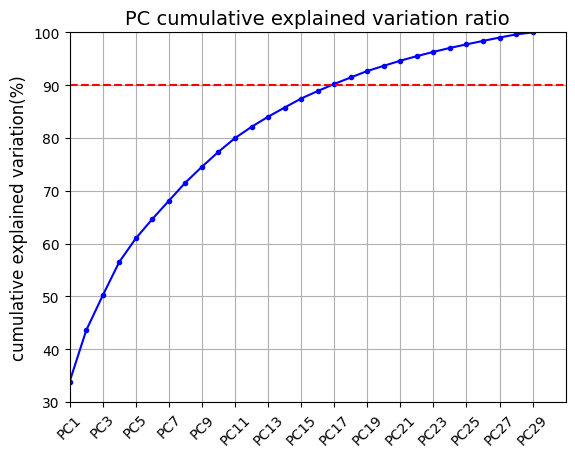

In [7]:
# PCA
explained_critical=0.9

eigenvalues,eigenvectors=np.linalg.eig(c)
idx=eigenvalues.argsort()[::-1]
eigenvalues=eigenvalues[idx]
eigenvectors=eigenvectors[:,idx]
explained_var_ratio=eigenvalues/np.sum(eigenvalues)
explained_var=np.cumsum(eigenvalues)/np.sum(eigenvalues)
n_components=np.argmax(explained_var>=explained_critical)+1
u=eigenvectors[:,:n_components]
pca_idx = np.array([f'PC{i+1}' for i in range(n_components)])
pca_component=pd.DataFrame(u,index=features,columns=pca_idx)

# project to new basis
z_projected=z@pca_component
z_restructured=z_projected@u.T
x_restructured=z_restructured*x_std+x_mean

sns.heatmap(pca_component,cmap='coolwarm')
plt.title('Principal Components')
plt.savefig('PC.jpg',dpi=150)
plt.show()
plt.clf()

plt.plot(np.array(explained_var*100),'.b-')
plt.ylabel('cumulative explained variation(%)',fontsize=12)
plt.title('PC cumulative explained variation ratio',fontsize=14)
plt.hlines(y=explained_critical*100,xmin=0,xmax=30,color='r',linestyle='dashed')
plt.xticks(np.arange(0,30,2),[f'PC{i+1}'for i in range(0,30,2)],rotation=45)
plt.xlim(0,30)
plt.ylim(30,100)
plt.grid()
plt.savefig('pc_explained.jpg',dpi=150)
plt.show()

### Below code are generated by Chat GPT
#### [對話紀錄](https://chatgpt.com/share/68fe319b-8ee8-800c-b392-ec45dcdeb70f)

In [8]:
# split data
RANDOM_SEED=42

x=x.values
y=y.values

x_normal=x[y==0]
x_fraud=x[y==1]

x_normal_train,x_normal_valid=train_test_split(x_normal,test_size=0.3,random_state=RANDOM_SEED)
x_valid=np.vstack([x_normal_valid,x_fraud])
y_valid=np.hstack([np.zeros(len(x_normal_valid)),np.ones(len(x_fraud))])

x_normal_test=x_normal_train[:len(x_normal_train)//2]

In [9]:
# Pytorch dataset
BATCH_SIZE=256

train_dataset=TensorDataset(torch.from_numpy(x_normal_train.astype(np.float32)))
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

valid_dataset=TensorDataset(torch.from_numpy(x_valid.astype(np.float32)),torch.from_numpy(y_valid.astype(np.int64)))
valid_loader=DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [10]:
# autoencoder
class AutoEncoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=16):
        super().__init__()
        # encoder
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,hidden_dim),            
        )

        # decoder
        self.decoder=nn.Sequential(
            nn.Linear(hidden_dim,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,input_dim),
        )
    def forward(self,x):
        z=self.encoder(x)
        x_rec=self.decoder(z)
        return x_rec

In [11]:
# create model
HIDDEN_DIM=16
input_dim=x.shape[1]
model=AutoEncoder(input_dim,hidden_dim=HIDDEN_DIM)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
model=model.to(device)

optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.MSELoss(reduction='none')

Running on cuda


In [12]:
# train

MODEL_SAVEPATH = "ae_fraud.pth"
EPOCH=50

# best_val_loss = np.inf
# for epoch in range(EPOCH):
#     model.train()
#     train_losses = []
#     for batch in train_loader:
#         x_batch = batch[0].to(device)
#         optimizer.zero_grad()
#         x_rec = model(x_batch)
#         loss = criterion(x_rec, x_batch).mean()  # 平均 over features and batch
#         loss.backward()
#         optimizer.step()
#         train_losses.append(loss.item())
#     train_loss = np.mean(train_losses)

#     # 驗證 loss：用 validation 所有樣本（含 fraud 也計算重建誤差）
#     model.eval()
#     with torch.no_grad():
#         val_recon_errors = []
#         for xb, yb in valid_loader:
#             xb = xb.to(device)
#             xr = model(xb)
#             # per-sample MSE (mean over features)
#             per_feat_mse = ((xr - xb) ** 2).mean(dim=1).cpu().numpy()
#             val_recon_errors.extend(per_feat_mse)
#         val_loss = np.mean(val_recon_errors)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), MODEL_SAVEPATH)

#     if epoch % 5 == 0 or epoch == 1:
#         print(f"Epoch {epoch}/{EPOCH} train_loss={train_loss:.6f} val_mse={val_loss:.6f}")


best_val_loss = np.inf
avg_train_losses = []
avg_val_losses = []

for epoch in range(EPOCH):
    model.train()
    train_losses = []

    # ---- Training loop ----
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH}"):
        x_batch=batch[0].to(device)
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred,x_batch).mean()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # ---- Validation loop ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in valid_loader:
            x_batch = batch[0].to(device) if isinstance(batch, (tuple, list)) else batch.to(device)
            x_rec = model(x_batch)
            loss = criterion(x_rec, x_batch).mean()
            val_losses.append(loss.item())


    # ---- Epoch summary ----
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    avg_train_losses.append(train_loss)
    avg_val_losses.append(val_loss)

    # 儲存目前最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVEPATH)
        print(f"Best model saved (epoch {epoch+1}, val_loss={val_loss:.6f})")

    # 每隔幾輪輸出一次結果
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCH}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


Epoch 1/50: 100%|██████████| 778/778 [00:02<00:00, 284.26it/s]


Best model saved (epoch 1, val_loss=18.669359)
Epoch [1/50] | Train Loss: 257789.228259 | Val Loss: 18.669359


Epoch 2/50: 100%|██████████| 778/778 [00:02<00:00, 344.43it/s]


Best model saved (epoch 2, val_loss=3.927080)


Epoch 3/50: 100%|██████████| 778/778 [00:02<00:00, 365.79it/s]


Best model saved (epoch 3, val_loss=3.368136)


Epoch 4/50: 100%|██████████| 778/778 [00:02<00:00, 360.92it/s]


Best model saved (epoch 4, val_loss=1.902553)


Epoch 5/50: 100%|██████████| 778/778 [00:02<00:00, 341.74it/s]


Epoch [5/50] | Train Loss: 5.846866 | Val Loss: 3.414898


Epoch 8/50: 100%|██████████| 778/778 [00:02<00:00, 361.78it/s]


Best model saved (epoch 8, val_loss=1.529292)


Epoch 10/50: 100%|██████████| 778/778 [00:02<00:00, 336.01it/s]


Epoch [10/50] | Train Loss: 41.452137 | Val Loss: 2.082125


Epoch 15/50: 100%|██████████| 778/778 [00:02<00:00, 340.75it/s]


Epoch [15/50] | Train Loss: 33.685690 | Val Loss: 503.716881


Epoch 20/50: 100%|██████████| 778/778 [00:02<00:00, 338.58it/s]


Epoch [20/50] | Train Loss: 37.639333 | Val Loss: 5.835020


Epoch 25/50: 100%|██████████| 778/778 [00:02<00:00, 361.31it/s]


Epoch [25/50] | Train Loss: 31.556476 | Val Loss: 2.469292


Epoch 30/50: 100%|██████████| 778/778 [00:02<00:00, 365.99it/s]


Epoch [30/50] | Train Loss: 26.795075 | Val Loss: 1.660781


Epoch 35/50: 100%|██████████| 778/778 [00:02<00:00, 366.80it/s]


Epoch [35/50] | Train Loss: 30.437490 | Val Loss: 5.012724


Epoch 40/50: 100%|██████████| 778/778 [00:02<00:00, 365.29it/s]


Epoch [40/50] | Train Loss: 26.601260 | Val Loss: 2.855289


Epoch 45/50: 100%|██████████| 778/778 [00:02<00:00, 340.19it/s]


Epoch [45/50] | Train Loss: 25.460333 | Val Loss: 9.797437


Epoch 50/50: 100%|██████████| 778/778 [00:02<00:00, 341.81it/s]


Epoch [50/50] | Train Loss: 36.021049 | Val Loss: 5.627564


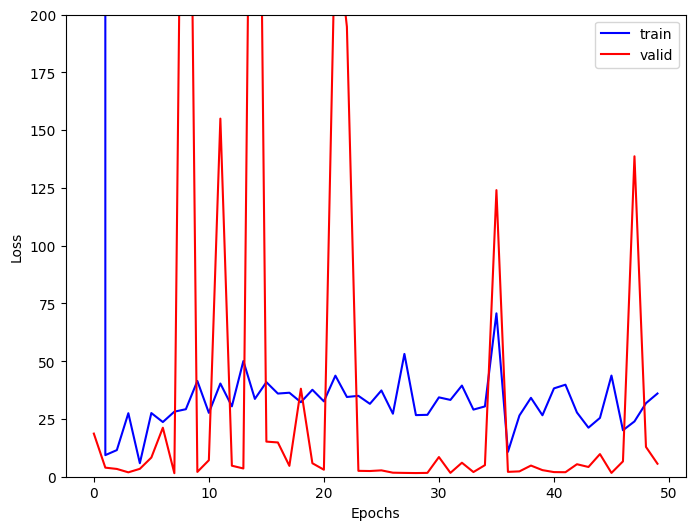

In [13]:
plt.figure(figsize=(8,6))
plt.plot(avg_train_losses,'b-',label='train')
plt.plot(avg_val_losses,'r-',label='valid')
plt.ylim(0,200)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.jpg',dpi=150)
plt.show()

ROC-AUC (using recon error as score): 0.6066
PR-AUC (average precision): 0.8283


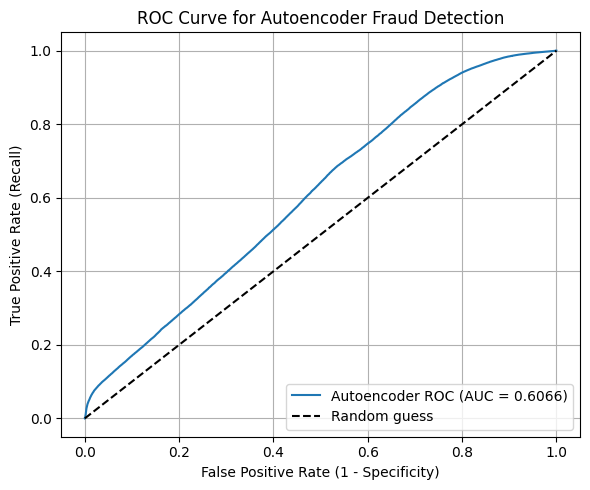


Threshold at train MSE quantile 0.980 -> thr=12.544467
              precision    recall  f1-score   support

         0.0     0.2411    0.9810    0.3871     85295
         1.0     0.9281    0.0738    0.1367    284315

    accuracy                         0.2831    369610
   macro avg     0.5846    0.5274    0.2619    369610
weighted avg     0.7696    0.2831    0.1945    369610

Confusion matrix:
 [[ 83671   1624]
 [263339  20976]]

Threshold at train MSE quantile 0.990 -> thr=13.136796
              precision    recall  f1-score   support

         0.0     0.2387    0.9899    0.3846     85295
         1.0     0.9457    0.0527    0.0998    284315

    accuracy                         0.2689    369610
   macro avg     0.5922    0.5213    0.2422    369610
weighted avg     0.7825    0.2689    0.1655    369610

Confusion matrix:
 [[ 84435    860]
 [269345  14970]]

Threshold at train MSE quantile 0.995 -> thr=13.834988
              precision    recall  f1-score   support

         0.0   

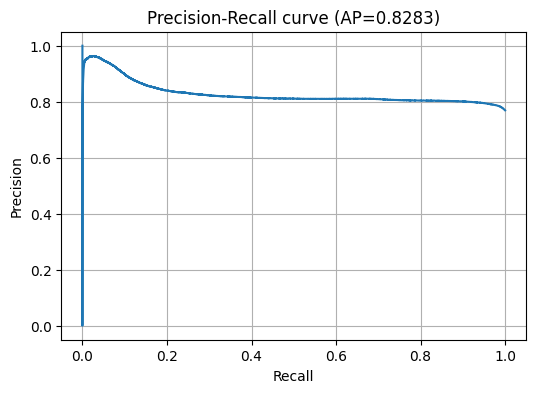

Best F1 on validation: 0.8696 at thr=0.063142


In [14]:
THRESHOLDS = [0.98, 0.99, 0.995]

with torch.no_grad():
    X_val_t = torch.from_numpy(x_valid.astype(np.float32)).to(device)
    X_val_rec = model(X_val_t)
    val_mse = ((X_val_rec - X_val_t) ** 2).mean(dim=1).cpu().numpy()  # per-sample MSE

# 基本指標：ROC-AUC、PR-AUC
rocauc = roc_auc_score(y_valid, val_mse)
pr_auc = average_precision_score(y_valid, val_mse)
print(f"ROC-AUC (using recon error as score): {rocauc:.4f}")
print(f"PR-AUC (average precision): {pr_auc:.4f}")

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 計算 ROC 曲線與 AUC
fpr, tpr, thresholds = roc_curve(y_valid, val_mse)
roc_auc = roc_auc_score(y_valid, val_mse)

# 繪圖
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Autoencoder ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Autoencoder Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC.jpg',dpi=150)
plt.show()


# 選 threshold：用 training 正常樣本的重建誤差分位數（常見做法）
# 計算 training 上的重建誤差分位數 (使用 train set)
with torch.no_grad():
    X_train_t = torch.from_numpy(x_normal_train.astype(np.float32)).to(device)
    X_train_rec = model(X_train_t)
    train_mse = ((X_train_rec - X_train_t) ** 2).mean(dim=1).cpu().numpy()

for q in THRESHOLDS:
    thr = np.quantile(train_mse, q)
    y_pred = (val_mse > thr).astype(int)
    print("\nThreshold at train MSE quantile {:.3f} -> thr={:.6f}".format(q, thr))
    print(classification_report(y_valid, y_pred, digits=4))
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion matrix:\n", cm)

# 可畫 precision-recall curve（threshold-free）
precision, recall, pr_th = precision_recall_curve(y_valid, val_mse)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AP={pr_auc:.4f})")
plt.grid(True)
plt.savefig('PR.jpg',dpi=150)
plt.show()

# 若想用 F1 選 threshold（在 validation 上搜尋最佳 F1）
from sklearn.metrics import f1_score

best_f1 = 0
best_thr = None
for thr in np.linspace(val_mse.min(), val_mse.max(), 200):
    y_p = (val_mse > thr).astype(int)
    f1 = f1_score(y_valid, y_p)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"Best F1 on validation: {best_f1:.4f} at thr={best_thr:.6f}")